In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import pickle
# load the dataset into memory
data_file = open("youtube_action_train_data_part1.pkl", 'rb')
data, labels = pickle.load(data_file)
data_file.close()

In [3]:
data.shape

(4000, 30, 64, 64, 3)

In [4]:
labels.shape

(4000,)

In [5]:
data = data/255.0

In [6]:
train_data = data[0:2800,:,:,:,:]
train_data.shape

(2800, 30, 64, 64, 3)

In [7]:
test_data = data[2800:,:,:,:,:]
test_data.shape

(1200, 30, 64, 64, 3)

In [8]:
train_labels = labels[0:2800]
test_labels = labels[2800:]

In [9]:
#Placeholders
X = tf.placeholder(shape=[None, 30, 64, 64, 3], dtype=tf.float32)
Y_ = tf.placeholder(shape=[None], dtype=tf.int32)
lr = tf.placeholder(dtype=tf.float32)

In [10]:
#Construct the Convolutional Neural Network
conv1 = tf.layers.conv3d(inputs=X, filters=32, kernel_size=[3,7,7], strides=(1, 1, 1), padding='valid', activation=tf.nn.relu)
conv1.shape
pool2 = tf.layers.max_pooling3d(inputs=conv1, pool_size=[1, 2, 2], strides=(1, 2, 2))
pool2.shape

TensorShape([Dimension(None), Dimension(28), Dimension(29), Dimension(29), Dimension(32)])

In [11]:
conv2 = tf.layers.conv3d(inputs=pool2, filters=32, kernel_size=[3,7,6], strides=(1, 1, 1), padding='valid', activation=tf.nn.relu)
conv2.shape

TensorShape([Dimension(None), Dimension(26), Dimension(23), Dimension(24), Dimension(32)])

In [12]:
pool3 = tf.layers.max_pooling3d(inputs=conv2, pool_size=[1, 3, 3], strides=(1, 2, 2))
pool3.shape

TensorShape([Dimension(None), Dimension(26), Dimension(11), Dimension(11), Dimension(32)])

In [13]:
conv4 = tf.layers.conv3d(inputs=pool3, filters=64, kernel_size=[1,7,4], strides=(1, 1, 1), padding='valid', activation=tf.nn.relu)
conv4.shape

TensorShape([Dimension(None), Dimension(26), Dimension(5), Dimension(8), Dimension(64)])

In [14]:
#pool5 = tf.layers.max_pooling3d(inputs=conv4, pool_size=[1, 2, 2], strides=(1, 2, 2))
#pool5.shape

TensorShape([Dimension(None), Dimension(24), Dimension(2), Dimension(2), Dimension(64)])

In [14]:
fully_connected = tf.reshape(conv4, (-1, 26, 2560))
fully_connected.shape

TensorShape([Dimension(None), Dimension(26), Dimension(2560)])

In [15]:
rnn_input = tf.layers.dense(inputs=fully_connected, units=128, activation=tf.nn.relu)

In [16]:
num_units = 128
lstm_cell = tf.nn.rnn_cell.LSTMCell(num_units)
h_val, _ = tf.nn.dynamic_rnn(lstm_cell, rnn_input, dtype=tf.float32)

In [17]:
#Feed the input to the RNN
seq_length = 26
final_output = tf.zeros(shape=[tf.shape(X)[0], 0, 30])
w_fc = tf.Variable(tf.truncated_normal([num_units, 30], stddev=0.1), name='final_weight')
b_fc = tf.Variable(tf.constant(0.1, tf.float32, [30]), name='last_bias')
for i in np.arange(seq_length):
    temp = tf.reshape(h_val[:, i, :], [-1, num_units])
    output = tf.matmul(temp, w_fc) + b_fc
    output = tf.reshape(output, [-1, 1, 30])
    final_output = tf.concat([final_output, output], axis=1)

In [18]:
final_output.shape

TensorShape([Dimension(None), Dimension(26), Dimension(30)])

In [24]:
final_output = tf.reshape(final_output, (-1, 780))
final_output.shape

TensorShape([Dimension(None), Dimension(780)])

In [26]:
final_weight = tf.Variable(tf.truncated_normal([780, 11], stddev=0.1), name='final_weight')
final_bias = tf.Variable(tf.constant(0.1, tf.float32, [11]), name='last_bias')
Y_logits = tf.matmul(final_output, final_weight) + final_bias
Y = tf.nn.softmax(Y_logits)

In [27]:
Y.shape

TensorShape([Dimension(None), Dimension(11)])

In [28]:
#Training the model with L2 regularization and Adam optimizer for backpropagation
beta = 0.001
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=Y_logits, labels=Y_)
print(cross_entropy)

cross_entropy = tf.reduce_mean(cross_entropy)
print(cross_entropy)
# accuracy of the trained model, between 0 (worst) and 1 (best)

correct_prediction = tf.equal(tf.cast(tf.argmax(Y, 1), dtype=tf.int32), Y_)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
predictions = tf.argmax(Y, 1)

# training step, the learning rate is a placeholder
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

Tensor("SparseSoftmaxCrossEntropyWithLogits_1/SparseSoftmaxCrossEntropyWithLogits:0", shape=(?,), dtype=float32)
Tensor("Mean_2:0", shape=(), dtype=float32)


In [30]:
#Get the relevant nodes and errors
import math
import numpy as np

tf.get_collection("validation_nodes")
# Add stuff to the collection.
tf.add_to_collection("validation_nodes", X)
tf.add_to_collection("validation_nodes", Y)
tf.add_to_collection("validation_nodes", Y_)
tf.add_to_collection("validation_nodes", predictions)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
training_epochs = 2500
learning_rate = 0.0008 

#Get training error and losses
training_error = []
testing_error = []
training_loss = []
testing_loss = []
for i in range(training_epochs):
    indices = np.random.randint(train_data.shape[0],size = 100)
    batch_X = train_data[indices]
    batch_Y = train_labels[indices]

    test_indices = np.random.randint(test_data.shape[0],size = 100)
    test_batch_X = test_data[test_indices]
    test_batch_Y = test_labels[test_indices]
    # compute training values
    if i % 10 == 0:
        '''
        When we sess.run here, we are calculating the accuracy and cross_entropy of the model on batch_X and batch_Y (ie. on 100 pieces of data)
        '''
        a, c= sess.run([accuracy, cross_entropy], {X: batch_X, Y_: batch_Y})
        #temp = sess.run([correct_prediction], feed_dict={X: batch_X, Y_: batch_Y})
        print(str(i) + ": training accuracy:" + str(a) + " training loss: " + str(c) + " (lr:" + str(learning_rate) + ")")
        training_error.append(1 - a)
        training_loss.append(c)
        
    # compute test values
    if i % 20 == 0:
        '''
        When we sess.run here, we are calculating the accuracy and cross_entropy of the model on all of the data
        '''
        a, c= sess.run([accuracy, cross_entropy], {X: test_batch_X, Y_: test_batch_Y})
        print(str(i) + ": test accuracy:" + str(a) + " test loss: " + str(c))
        testing_error.append(1 - a)
        testing_loss.append(c)
        
    # the backpropagation training step
    sess.run(train_step, {X: batch_X, Y_: batch_Y, lr: learning_rate})

    if i % 40 == 0:
        saver = tf.train.Saver()
        save_path = saver.save(sess, "models/my_model_" + str(i))

0: training accuracy:0.27 training loss: 2.2876673 (lr:0.0008)
0: test accuracy:0.0 test loss: 2.5122561
10: training accuracy:0.24 training loss: 1.5378703 (lr:0.0008)
20: training accuracy:0.43 training loss: 1.485999 (lr:0.0008)
20: test accuracy:0.0 test loss: 4.995012
30: training accuracy:0.47 training loss: 1.3536519 (lr:0.0008)
40: training accuracy:0.6 training loss: 1.0108052 (lr:0.0008)
40: test accuracy:0.0 test loss: 5.6265745
50: training accuracy:0.52 training loss: 1.1781634 (lr:0.0008)
60: training accuracy:0.72 training loss: 0.8353901 (lr:0.0008)
60: test accuracy:0.0 test loss: 4.7076206
70: training accuracy:0.72 training loss: 0.7400185 (lr:0.0008)
80: training accuracy:0.76 training loss: 0.79247093 (lr:0.0008)
80: test accuracy:0.0 test loss: 5.08467
90: training accuracy:0.78 training loss: 0.52361643 (lr:0.0008)
100: training accuracy:0.85 training loss: 0.4890892 (lr:0.0008)
100: test accuracy:0.05 test loss: 5.798319
110: training accuracy:0.86 training loss

KeyboardInterrupt: 

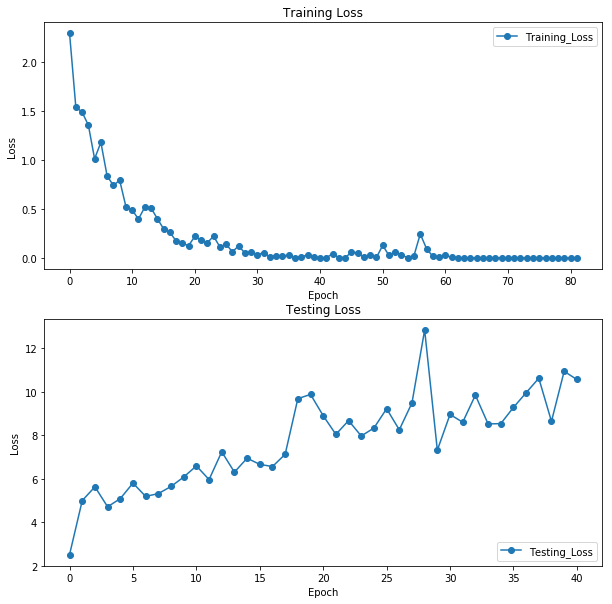

In [31]:
#Plotting the training and testing losses
plt.subplot(2,1,1)
plt.plot(training_loss, '-o', label='Training_Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(ncol=2, loc='upper right')
plt.subplot(2,1,2)
plt.plot(testing_loss, '-o', label='Testing_Loss')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(ncol=2, loc='lower right')
plt.gcf().set_size_inches(10, 10)
plt.savefig('Training_and_testing_loss.png')

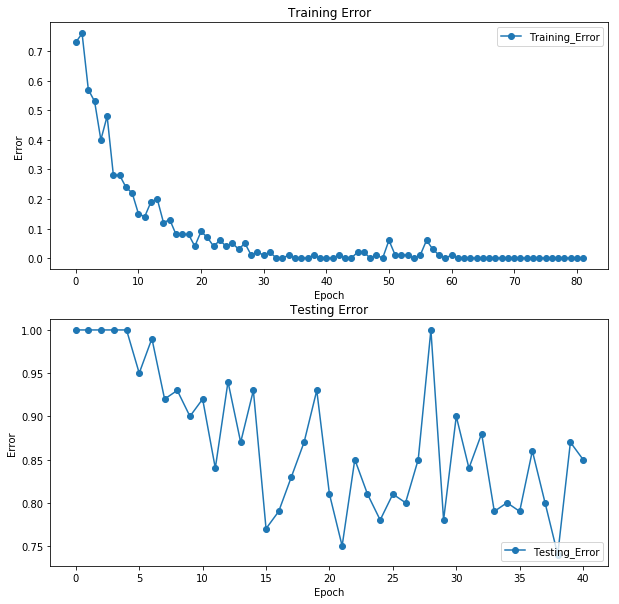

In [32]:
#Plottting the error and loss curves
import matplotlib.pyplot as plt
plt.subplot(2,1,1)
plt.plot(training_error, '-o', label='Training_Error')
plt.title('Training Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(ncol=2, loc='upper right')
plt.subplot(2,1,2)
plt.plot(testing_error, '-o', label='Testing_Error')
plt.title('Testing Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(ncol=2, loc='lower right')
plt.gcf().set_size_inches(10, 10)
plt.savefig('Training_and_testing_error.png')